Este é um notebook novo com fortes alterações que não queria estar a fazer no outro, o outro ainda se encontra na secção de notebooks. Removi alguns métodos daqui para tornar o código um pouco mais legível  e os betas dos outputs. Este notebook não é (em principio) o que vamos mandar mas estava-me a sentir overwelmed com o outro

### Abstract

The objective is to choose the best model for a given data, thus we need to make several models  with a portion of the data and evaluating the best model possible by choosing the one with the lowest SSE. After choosing the best model is necessary to create a new model with all training data avaiable in order to create outputs for the real data.

# Import Libraries

In [1]:
import numpy as np
import random
from matplotlib import pyplot as plt
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures,  StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, RepeatedKFold, GridSearchCV


# Import Train Data

In [2]:
X_import = np.load("data/Xtrain_Regression1.npy")
Y_import = np.load("data/Ytrain_Regression1.npy")
# create global functions to store the splitted data
X_train,Y_train,X_test,Y_test = 0,0,0,0

# Essencial Functions

In [3]:
def split_data(x_import,y_import,test_siz):
    '''Splits the data according to the test_siz fraction'''
    x_train, x_test, y_train, y_test = train_test_split(x_import, y_import, test_size=test_siz)
    return (x_train,y_train,x_test,y_test)


def refresh_data(div):
    '''Refreshes the data split'''
    global X_train,Y_train,X_test,Y_test
    (X_train,Y_train,X_test,Y_test) = split_data(X_import,Y_import,div)

def calc_SSE(y_pred,y):
    '''Calculates the SSE from the predicted data'''
    return np.sum((y_pred - y)**2)

def calc_SSE_beta(x,y,beta):
    '''Calculated the SSE from the X and beta matrix'''
    col_ones = np.ones((np.shape(x)[0],1))
    X = np.hstack([col_ones,x])
    SSE = np.linalg.norm(y - np.matmul(X,beta))**2
    return SSE 

def beta_from_model(model):
    '''Returns the complete beta matrix from the model'''
    beta = model.coef_[0]
    beta[0] = model.intercept_[0]
    return beta 
   
def Average(lst):
    '''Returns the average of a list'''
    return round(sum(lst)/len(lst),2)

# Linear Model

In [4]:
def linear_model(x, y):
    '''Creates and returns a simple linear regression model of order 1'''
    LR = LinearRegression()
    LR.fit(x,y)
    return LR

def test_linear_model(x_train,y_train,x_test,y_test,iters):
    '''Tests the linear model returning a simple SSE value'''

    SSE_lst = []

    for i in range(iters):
        refresh_data(0.2)
        model_sl = linear_model(X_train, Y_train)
        y_pred = model_sl.predict(X_test)
        SSE_lst.append(calc_SSE(y_pred, Y_test))

    SSE_avg = Average(SSE_lst)
    SSE_std = np.std(SSE_lst)

    return(SSE_avg,SSE_std)

SSE_lin = test_linear_model(X_train,Y_train,X_test,Y_test,500)
print("Average SSE :", SSE_lin[0], "+/-", SSE_lin[1])

Average SSE : 0.25 +/- 0.06739017265048242


# Polynomial Model

SSE order 1 : 0.26 +/- 0.06672935822240895
SSE order 2 : 9.96 +/- 22.907191663295613
SSE order 3 : 30.27 +/- 11.101996360046313
SSE order 4 : 81.18 +/- 36.12308986343792


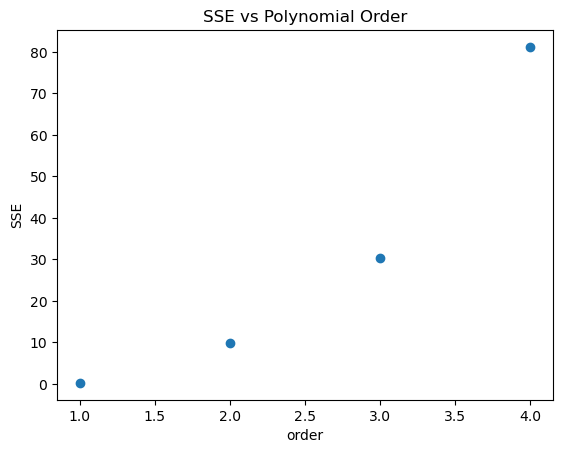

In [5]:
def polynomial_model(x, y, deg):
    '''Creates the polynomial model'''

    poly = PolynomialFeatures(degree=deg, include_bias=True)  
    poly_features = poly.fit_transform(x)  
    poly_reg_model = LinearRegression()  
    poly_reg_model.fit(poly_features, y)
    return poly_reg_model, poly

def test_polynomial_model(deg_max,iters,show_plots=True):
    '''Tests the polynomial model up to deg_max'''

    order_list, SSE, SSE_plt = [i for i in range(1,deg_max+1)], [], []

    def get_avg_sse(i):
        '''Returns the average SSE for a given polynomial degree'''
        SSE_lst = []
        for s in range(1,iters):
            refresh_data(0.2)
            (model,poly) = polynomial_model(X_train,Y_train,i)
            x_test_trans = poly.transform(X_test)
            y_pred = model.predict(x_test_trans)
            SSE_lst.append(calc_SSE(y_pred,Y_test))
        return [Average(SSE_lst), np.std(SSE_lst)]
        

    for i in range(1,deg_max+1):
        SSE.append(get_avg_sse(i))
        SSE_plt.append(SSE[-1][0])
    
    
    if show_plots:
        plt.scatter(order_list, SSE_plt)
        plt.xlabel('order')
        plt.ylabel('SSE')
        plt.title('SSE vs Polynomial Order')
        
        return SSE, plt
    
    else:
        return SSE


SSE_pol, plot_pol = test_polynomial_model(4,500,show_plots=True)
for i in range(len(SSE_pol)):
    print("SSE order",i+1,":",SSE_pol[i][0], "+/-", SSE_pol[i][1])
plot_pol.show()

# Ridge Model

Average SSE: 0.25 +/- 0.07225536818683007 
Alpha: 0.1


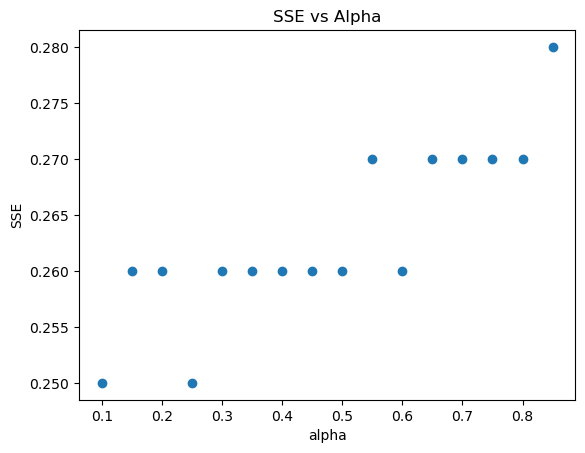

In [6]:
def ridge_model(x,y,alpha):
    '''This function creates a ridge model'''
    model = Ridge(alpha=alpha)
    model.fit(x,y)
    return model

def test_ridge_model(iters,show_plots=True):
    '''This function tests the ridge model'''
    alpha_list = [i for i in np.arange(0.1,0.9,0.05)]
    SSE, std = [], []

    def get_avg_sse(alpha):
        '''Returns the average SSE for a given alpha'''
        SSE_lst = []
        for s in range(1,iters):
            refresh_data(0.2)
            model = ridge_model(X_train,Y_train,alpha)
            y_pred = model.predict(X_test)
            SSE_lst.append(calc_SSE(y_pred,Y_test))
        return [Average(SSE_lst), np.std(SSE_lst)]

    for alpha in alpha_list:
        SSE_std = get_avg_sse(alpha)
        SSE.append(SSE_std[0])
        std.append(SSE_std[1])

    min_SSE = min(SSE)
    min_SSE_index = SSE.index(min_SSE)
    min_alpha = alpha_list[min_SSE_index]
    min_std = std[min_SSE_index]

    if show_plots:    
        plt.scatter(alpha_list, SSE)
        plt.xlabel('alpha')
        plt.ylabel('SSE')
        plt.title('SSE vs Alpha')
        return min_SSE, min_std, min_alpha, plt
    else:
        return min_SSE, min_std, min_alpha

    
SSE_rid, std_rid, alpha_rid, plot_rid = test_ridge_model(1500)
print("Average SSE:", SSE_rid ,"+/-",std_rid, "\nAlpha:",alpha_rid)
plot_rid.show()

In [ ]:
def ridgecv_model(x,y,alph,cvs):
    '''This function creates a ridge model'''
    model = RidgeCV(alpha=alph,cv = cvs, normalize=True,store_cv_values = True)
    model.fit(x,y)
    return model

def test_ridge_model(iters,show_plots=True):
    '''This function tests the ridge model'''
    alpha_list = [i for i in np.arange(0.1,0.9,0.05)]
    SSE, std = [], []

    def get_avg_sse(alpha,cv):
        '''Returns the average SSE for a given alpha'''
        SSE_lst = []
        for s in range(1,iters):
            # refresh_data(0.2)
            model = ridgecv_model(X_train,Y_train,alpha,cv)
            y_pred = model.predict(X_test)
            SSE_lst.append(calc_SSE(y_pred,Y_test))
        return [Average(SSE_lst), np.std(SSE_lst)]

    for alpha in alpha_list:
        SSE_std = get_avg_sse(alpha)
        SSE.append(SSE_std[0])
        std.append(SSE_std[1])

    min_SSE = min(SSE)
    min_SSE_index = SSE.index(min_SSE)
    min_alpha = alpha_list[min_SSE_index]
    min_std = std[min_SSE_index]

    if show_plots:    
        plt.scatter(alpha_list, SSE)
        plt.xlabel('alpha')
        plt.ylabel('SSE')
        plt.title('SSE vs Alpha')
        return min_SSE, min_std, min_alpha, plt
    else:
        return min_SSE, min_std, min_alpha

    
SSE_rid, std_rid, alpha_rid, plot_rid = test_ridge_model(1500)
print("Average SSE:", SSE_rid ,"+/-",std_rid, "\nAlpha:",alpha_rid)
plot_rid.show()

# Lasso Model

In [7]:
def lasso_model(x_train,y_train,alpha,method=2):
    '''Creates a lasso model'''
    model_lasso = Lasso(alpha=alpha)
    model_lasso.fit(x_train,y_train)
    return model_lasso

def test_lasso_model(iters,show_plots=True):
    '''This function tests the lasso model'''
    alpha_list = [i for i in np.arange(0.1,100.0,0.1)]
    SSE, std = [], []

    def get_avg_sse(alpha):
        '''Returns the average SSE for a given alpha'''
        SSE_lst = []
        for s in range(1,iters):
            refresh_data(0.2)
            scaler = StandardScaler().fit(X_train[list_numerical]) 
            x_train[list_numerical] = scaler.transform(X_train[list_numerical])
            x_test[list_numerical] = scaler.transform(X_test[list_numerical])
            

            model = lasso_model(X_train,Y_train,alpha,method=2)
            y_pred = model.predict(X_test)
            SSE_lst.append(calc_SSE(y_pred,Y_test))

        return [Average(SSE_lst), np.std(SSE_lst)]

    for alpha in alpha_list:
        SSE_std = get_avg_sse(alpha)
        SSE.append(SSE_std[0])
        std.append(SSE_std[1])

    min_SSE = min(SSE)
    min_SSE_index = SSE.index(min_SSE)
    min_alpha = alpha_list[min_SSE_index]
    min_std = std[min_SSE_index]

    if show_plots:    
        plt.plot(alpha_list, SSE)
        plt.xlabel('alpha')
        plt.ylabel('SSE')
        plt.title('SSE vs Alpha')
        return min_SSE, min_std, min_alpha, plt
    else:
        return min_SSE, min_std, min_alpha
    
SSE_lss, std_lss, alpha_lss, plot_lss = test_lasso_model(50)
print("Average SSE:", SSE_lss ,"+/-",std_lss, "\nAlpha:",alpha_lss)
plot_lss.show()

NameError: name 'list_numerical' is not defined

## Conclusions

Let's assume Ridge is the best model due to a marginal difference in SSE

In [ ]:
x_eval_import = np.load("data/Xtest_Regression1.npy")
model = ridge_model(X_import,Y_import,0.25)
y_pred = model.predict(x_eval_import)
y_pred

array([[ 7.80195193e+00],
       [-1.96883723e-01],
       [ 4.71245974e+00],
       [ 1.19744945e+00],
       [-1.86351197e+00],
       [ 1.81021529e+00],
       [ 2.19489342e+00],
       [ 3.04206821e+00],
       [-1.46082553e+00],
       [ 3.44595437e+00],
       [ 2.14693428e+00],
       [-5.88978380e-01],
       [ 1.88567790e+00],
       [ 4.36065559e+00],
       [-2.77010594e+00],
       [-2.12441349e+00],
       [-2.10867812e+00],
       [-3.70579322e+00],
       [ 4.16847337e-01],
       [-2.82423147e+00],
       [ 3.47886080e-01],
       [ 2.15184845e+00],
       [ 4.14843312e-01],
       [ 7.07190428e-01],
       [ 9.83342811e-01],
       [ 3.50490233e-01],
       [-1.01578143e+00],
       [-3.97650054e-01],
       [-2.18972235e+00],
       [ 5.40661102e+00],
       [-9.15927469e-01],
       [ 7.02005771e+00],
       [-3.73699700e+00],
       [ 3.90640562e-02],
       [-9.16679155e-01],
       [ 3.61057090e+00],
       [ 3.55839403e+00],
       [ 2.05136955e+00],
       [ 1.0

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=25889058-66de-44c8-ad64-ee695f6c1052' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>